In [7]:
from imp import reload
import os, time
import numpy as np
import pickle
from helpers import comp_evs

# RNN model and task
import torch
use_cuda = torch.cuda.is_available()
from model import RNN, train, run_net
from task_generators import input_driven_fp
task_generator = input_driven_fp
import matplotlib.pyplot as plt
# Data directory for saving
from data_dir import data_dir

# Name
file_name_prefix = "linear" 
torch.cuda.set_device("cuda:2")

In [2]:
# Optimizer
optimizer = 'sgd'

# Nonlinearity
nonlinearity = 'id'

# Integration time step
dt = 0.5
# Training parameters
batch_size = 1
batch_size_test = 1
# Neural noise
noise_std = 0.0
# Whether IO vectors are orthogonalized
orthogonalize_wio = False
# Same random connectivity for each g?
same_connectivity = False

# Number of epochs
n_epochs = 200
# Record the weights only every 'rec_step'
rec_step = 1

# Network parameters
dim_in = 1
dim_out = dim_in

In [3]:
scenario = ['fig_3_4', 'supp_fig_diverge', 'test'][0]

if scenario == 'fig_3_4':
    # Fig 3,4
    dim_rec = 1024

    # Train for different randomness
    dg = 0.1
    gs = np.arange(0, 1, dg)

    # Number of samples
    n_samples = 5

    # Task
    # Target amplitudes
    target_amps = np.array([0.5, 1.0, 2.0])
    # Trail time
    t_max = 101
    # Learning rates for g == 0
    lr0s = np.array([0.015, 0.009, 0.003])

    compute_evs = False

elif scenario == 'supp_fig_diverge':
    # Diverging learning for supplementary
    dim_rec = 256

    # Initial connectivity strength
    gs = np.array([0.6, 0.8])

    # Number of samples
    n_samples = 5

    # Target amplitudes
    # target_amps = np.array([1., 2., 3., 4.])
    target_amps = np.array([2., 4.])
    # Trail time
    t_max = 201
    # Learning rates for g == 0
    # lr0s = np.array([0.009, 0.003, 0.002, 0.001])
    lr0s = np.array([0.002, 0.001])

    compute_evs = True
    file_name_prefix += "_diverge"

elif scenario == 'test':
    # Quick testing
    n_samples = 1
    dim_rec = 256
    n_epochs = 20
    t_max = 21
    gs = np.array([0.0, 0.6])
    target_amps = np.array([0.5, 2.])
    lr0s = np.array([0.01, 0.005])
    file_name_prefix = "test_" + file_name_prefix
    compute_evs = False

In [4]:
# Network dimensions
dims = [dim_in, dim_rec, dim_out]

# All task parameters
task_params_all = [{"t_max": t_max, 
                    "fixation_duration": 1,
                    "decision_duration": 1,
                    "input_amp": 1,
                    "target_amp": target_amp,}
                   for target_amp in target_amps]

# Learning rates
lrs_all = lr0s[:, None] * (1 - gs[None, :]**2)**2

# Epochs
n_rec_epochs = n_epochs // rec_step
epochs = np.arange(n_epochs)
rec_epochs = np.arange(0, n_epochs, rec_step)
# Learning times
tls_all = lrs_all[:, :, None] * epochs[None, None, :]

# Results arrays
n_gs = len(gs)
n_tas = len(target_amps)
# Weights
wi_init_all = np.zeros((n_samples, n_tas, n_gs, dim_in, dim_rec))
wo_init_all = np.zeros((n_samples, n_tas, n_gs, dim_rec, dim_out))
wrec_init_all = np.zeros((n_samples, n_tas, n_gs, dim_rec, dim_rec))
dwrec_last_all = np.zeros((n_samples, n_tas, n_gs, dim_rec, dim_rec))
# Results
losses_all = np.zeros((n_samples, n_tas, n_gs, n_epochs))
grad_norms_all = np.zeros((n_samples, n_tas, n_gs, n_epochs))
ev_w_all = np.zeros((n_samples, n_tas, n_gs, n_epochs, dim_rec), dtype=complex)
sv_dw_all = np.zeros((n_samples, n_tas, n_gs, n_rec_epochs, dim_rec))
loss_shuff_all = np.zeros((n_samples, n_tas, n_gs))

# File name
file_name = file_name_prefix
if n_tas == 1:
    target_amp = target_amps[0]
    file_name += "_zhat_%.1f"%target_amp
else:
    file_name += "_zhats"
if n_gs == 1:
    g = gs[0]
    file_name += "_g_%.1f" % g
else:
    file_name += "_gs"
if optimizer != 'sgd':
    file_name += '_' + optimizer
if same_connectivity:
    file_name += "_same_conn"
if orthogonalize_wio:
    file_name += "_ortho_wio"
if noise_std != 0:
    file_name += "_noise_%.1f"%noise_std
# Network parameters
file_name += "_N_%d" % dim_rec
file_name += "_tmax_%d" % t_max
file_name = "".join(file_name.split('.'))
print("file_name:\n", file_name)

# Data file for saving
data_file_name = file_name + ".pkl"
data_file = os.path.join(data_dir, data_file_name)
print("data_file:\n", data_file)


file_name:
 linear_zhats_gs_N_1024_tmax_101
data_file:
 ../data/linear_zhats_gs_N_1024_tmax_101.pkl


In [5]:
%%time

time_t = 0
time_ev = 0
time_sv = 0
time_ls = 0
all_results = {}
for k in range(1):
    print(k)
    
    for j in range(n_tas):
        task_params = task_params_all[j]
        task = task_generator(dims, dt, **task_params)
        i = n_gs//2
        g = gs[i]
        lr = lrs_all[j, i]

        if (not same_connectivity) or (i == 0 and j == 0):
            # Initial connectivity
            # Random component
            wrec_0 = np.random.normal(0, 1 / np.sqrt(dim_rec), (dim_rec, dim_rec))
            # Input and readout
            wio = np.random.normal(0, 1, (dim_rec, dim_in + dim_out))
            if orthogonalize_wio:
                wio = np.linalg.qr(wio)[0]
            else:
                wio /= np.linalg.norm(wio, axis=0)[None, :]
            # Make sure that the vecotrs are still normalized
            assert np.allclose(np.linalg.norm(wio, axis=0), 1), "Normalization gone wrong!"
            # Change normalization to the proper one
            wio *= np.sqrt(dim_rec)
            wi_init = wio[:, :dim_in].T.copy()
            wo_init = wio[:, dim_in:].copy() / dim_rec
            del wio

        wrec_init = g * wrec_0

        # Network
        net = RNN(dims, noise_std, dt, nonlinearity, g=g, wi_init=wi_init, wo_init=wo_init, wrec_init=wrec_init)
        
        # Train
        time0_t = time.time()
        res = train(net, task, n_epochs, batch_size, lr, cuda=use_cuda, rec_step=rec_step, optimizer=optimizer, verbose=False)
        losses, grad_norms, weights_init, weights_last, weights_train, _, _ = res
        # Weights
        all_results[j] = res

# Readout
target_amp = task_params["target_amp"]
zs_all = target_amps[None, :, None, None] - np.sqrt(2 * losses_all)


0


loss: 6.39e-14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:18<00:00, 11.04it/s]


CPU times: user 1min 10s, sys: 4.65 s, total: 1min 14s
Wall time: 1min 2s


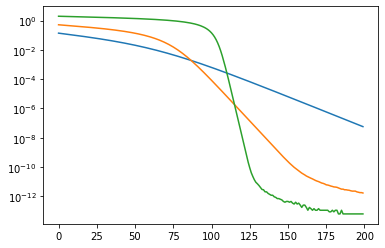

In [6]:
for res in all_results.values():
    losses, grad_norms, weights_init, weights_last, weights_train, _, _ = res
    plt.semilogy(losses)

time_t = 0
time_ev = 0
time_sv = 0
time_ls = 0
for k in range(n_samples):
    print(k)
    
    for j in range(n_tas):
        task_params = task_params_all[j]
        task = task_generator(dims, dt, **task_params)

        for i in range(n_gs):
            g = gs[i]
            lr = lrs_all[j, i]

            if (not same_connectivity) or (i == 0 and j == 0):
                # Initial connectivity
                # Random component
                wrec_0 = np.random.normal(0, 1 / np.sqrt(dim_rec), (dim_rec, dim_rec))
                # Input and readout
                wio = np.random.normal(0, 1, (dim_rec, dim_in + dim_out))
                if orthogonalize_wio:
                    wio = np.linalg.qr(wio)[0]
                else:
                    wio /= np.linalg.norm(wio, axis=0)[None, :]
                # Make sure that the vecotrs are still normalized
                assert np.allclose(np.linalg.norm(wio, axis=0), 1), "Normalization gone wrong!"
                # Change normalization to the proper one
                wio *= np.sqrt(dim_rec)
                wi_init = wio[:, :dim_in].T.copy()
                wo_init = wio[:, dim_in:].copy() / dim_rec
                del wio

            wrec_init = g * wrec_0

            # Network
            net = RNN(dims, noise_std, dt, nonlinearity, g=g, wi_init=wi_init, wo_init=wo_init, wrec_init=wrec_init)

            # Train
            time0_t = time.time()
            res = train(net, task, n_epochs, batch_size, lr, cuda=use_cuda, rec_step=rec_step, optimizer=optimizer, verbose=False)
            losses, grad_norms, weights_init, weights_last, weights_train, _, _ = res
            # Weights
            wi_init, wrec_init, wo_init, brec_init = weights_init
            wi_last, wrec_last, wo_last, brec_last = weights_last
            dwrec_last = wrec_last - wrec_init
            wrecs = weights_train["wrec"]
            time_t += time.time() - time0_t

            # Compute EVs and SVs
            time0_ev = time.time()
            if compute_evs:
                if np.isnan(wrecs).any():
                    ev_w = np.zeros((n_rec_epochs, dim_rec), dtype=complex)
                    i_nan = np.argmax(np.isnan(wrecs[:, 0, 0])) - 1
                    ev_w[:i_nan] = comp_evs(wrecs[:i_nan])
                else:
                    ev_w = comp_evs(wrecs)
            time_ev += time.time() - time0_ev
            time0_sv = time.time()
            sv_dw = np.linalg.svd(wrecs - wrec_init, compute_uv=False)
            time_sv += time.time() - time0_sv
            
            ### Loss for shuffled network
            time0_ls = time.time()
            # Shuffle is in-place!  -> copy!
            wrec_init_shuff = wrec_init.copy()
            # Shuffle needs reshape
            wrec_init_shuff = wrec_init_shuff.reshape((dim_rec**2,))
            np.random.shuffle(wrec_init_shuff)
            wrec_init_shuff = wrec_init_shuff.reshape((dim_rec, dim_rec))
            wrec_shuff = wrec_init_shuff + dwrec_last
            # Run network
            net_shuff = RNN(dims, noise_std, dt, nonlinearity, g=g, wi_init=wi_init, wo_init=wo_init, wrec_init=wrec_shuff)
            res_shuff = run_net(net_shuff, task, batch_size=batch_size_test)
            _, _, _, _, loss_shuff = res_shuff
            time_ls += time.time() - time0_ls
            
            # Save
            wi_init_all[k, j, i] = wi_init
            wo_init_all[k, j, i] = wo_init
            wrec_init_all[k, j, i] = wrec_init
            dwrec_last_all[k, j, i] = dwrec_last
            losses_all[k, j, i] = losses
            grad_norms_all[k, j, i] = grad_norms
            if compute_evs:
                ev_w_all[k, j, i] = ev_w
            sv_dw_all[k, j, i] = sv_dw
            loss_shuff_all[k, j, i] = loss_shuff

print("Done. Learning took %.1f sec, EV/SV evaluation took %.1f / %.1f sec" % (time_t, time_ev, time_sv))
print("Computing loss after shuffle took %.1f sec" % (time_ls))

# Readout
target_amp = task_params["target_amp"]
zs_all = target_amps[None, :, None, None] - np.sqrt(2 * losses_all)

###############################################################################
# Save data
to_be_dumped = {
    # Simulation parameters
    "dims": dims,
    "dt": dt,
    "noise_std": noise_std,
    "n_epochs": n_epochs,
    "rec_step": rec_step,
    "epochs": epochs,
    "rec_epochs": rec_epochs,
    # Varied parameters
    "gs": gs,
    "target_amps": target_amps,
    "lr0s": lr0s,
    "n_gs": n_gs,
    "n_tas": n_tas,
    "n_samples": n_samples,
    "lrs_all": lrs_all,
    "tls_all": tls_all,
    # Task
    "task_params_all": task_params_all,
    # Weights
    "wi_init_all": wi_init_all,
    "wo_init_all": wo_init_all,
    "wrec_init_all": wrec_init_all,
    "dwrec_last_all": dwrec_last_all,
    # Results
    "losses_all": losses_all,
    "ev_w_all": ev_w_all,
    "sv_dw_all": sv_dw_all,
    "zs_all": zs_all,
    "grad_norms_all": grad_norms_all,
    "loss_shuff_all": loss_shuff_all,
    # Computation time
    "time_t": time_t,
    "time_ev": time_ev,
    "time_sv": time_sv,
    "time_ls": time_ls,
}
with open(data_file, 'wb') as handle:
    pickle.dump(to_be_dumped, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Saved data to " + data_file + "\n")